In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split


In [2]:
class SmallCNN5(nn.Module):
    def __init__(self, input_channels=10, num_classes=2, image_shape=(50, 50)):
        super(SmallCNN5, self).__init__()

        H, W = image_shape

        # First CNN Layer
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.LayerNorm([32, H, W])
        self.act1 = nn.GELU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2

        # Depthwise Separable Convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.LayerNorm([64, H // 2, W // 2])
        self.act2 = nn.GELU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.pointwise = nn.Conv2d(64, 64, kernel_size=1)

        self.gap = nn.AdaptiveAvgPool2d((4, 4))

        # Fully Connected Layer
        self.cls_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 64),
            nn.RMSNorm(64),
            nn.GELU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.pointwise(x)
        x = self.gap(x)
        x = self.cls_head(x)

        return x


super_model = SmallCNN5(num_classes=2).to('cuda')
print(f"Total parameters: {sum(p.numel() for p in super_model.parameters() if p.requires_grad)}")
summary(super_model, (10,50,50))

Total parameters: 331362
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]           2,912
         LayerNorm-2           [-1, 32, 50, 50]         160,000
              GELU-3           [-1, 32, 50, 50]               0
         MaxPool2d-4           [-1, 32, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          18,496
         LayerNorm-6           [-1, 64, 25, 25]          80,000
              GELU-7           [-1, 64, 25, 25]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]           4,160
AdaptiveAvgPool2d-10             [-1, 64, 4, 4]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                   [-1, 64]          65,600
          RMSNorm-13                   [-1, 64]              64
             G

In [3]:
class SmallCNN4(nn.Module):
    def __init__(self, input_channels=10, num_classes=2):
        super(SmallCNN4, self).__init__()

        # First CNN Layer
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2

        # Depthwise Separable Convolution
        self.depthwise = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise = nn.Conv2d(32, 64, kernel_size=1)

        # Global Average Pooling to (2, 2)
        self.gap = nn.AdaptiveAvgPool2d((4, 4))

        # Fully Connected Layer
        self.fc = nn.Linear(64 * 4 * 4, num_classes)  # 64 channels with spatial size (2, 2)

    def forward(self, x):
        # First CNN Layer
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Depthwise Separable Convolution
        x = F.relu(self.pointwise(self.depthwise(x)))

        # Global Average Pooling
        x = self.gap(x).view(x.size(0), -1)

        # Fully Connected Layer
        x = self.fc(x)

        return x
    
    
super_model = SmallCNN4(num_classes=2).to('cuda')
print(f"Total parameters: {sum(p.numel() for p in super_model.parameters() if p.requires_grad)}")
summary(super_model, (10,50,50))

Total parameters: 7458
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]           2,912
       BatchNorm2d-2           [-1, 32, 50, 50]              64
         MaxPool2d-3           [-1, 32, 25, 25]               0
            Conv2d-4           [-1, 32, 25, 25]             320
            Conv2d-5           [-1, 64, 25, 25]           2,112
 AdaptiveAvgPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                    [-1, 2]           2,050
Total params: 7,458
Trainable params: 7,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 1.84
Params size (MB): 0.03
Estimated Total Size (MB): 1.96
----------------------------------------------------------------


In [4]:
class GeoTIFFDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images, organized in subfolders per class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        # self.classes = sorted(os.listdir(root_dir))
        self.classes = ['grass', 'legume']
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        
        # for cls in self.classes:
        #     cls_folder = os.path.join(root_dir, cls)
        #     for file in os.listdir(cls_folder):
        #         if file.endswith('.tif') or file.endswith('.tiff'):
        #             self.image_paths.append(os.path.join(cls_folder, file))
        #             self.labels.append(self.class_to_idx[cls])

        for file in os.listdir(root_dir):
            if file.endswith('.tif') or file.endswith('.tiff'):
                self.image_paths.append(os.path.join(root_dir, file))
                self.labels.append(self.class_to_idx[file.split('_')[1]])

    def __len__(self):
        return len(self.image_paths)
    
    def compute_indices(self, bands):
        """
        Compute NDVI, SAVI, VARI, EXG, NDRE indices.
        Args:
            bands (numpy array): Array of shape (6, H, W)
        Returns:
            indices (numpy array): Array of shape (5, H, W)
        """
        # Assuming band order: 0=Blue, 1=Green, 2=Red, 3=NIR, 4=RE, 5=SWIR
        blue = bands[0].astype(float)
        green = bands[1].astype(float)
        red = bands[2].astype(float)
        re = bands[3].astype(float)
        nir = bands[4].astype(float)
        # swir = bands[5].astype(float)  # Not used in indices here
        
        # NDVI
        ndvi = (nir - red) / (nir + red + 1e-6)
        
        # SAVI (L=0.5)
        L = 0.5
        savi = ((nir - red) / (nir + red + L)) * (1 + L)
        
        # VARI
        vari = (green - red) / (green + red - blue + 1e-6)
        
        # EXG
        exg = 2 * green - red - blue
        
        # NDRE
        ndre = (nir - re) / (nir + re + 1e-6)
        
        # Stack indices
        indices = np.stack([ndvi, savi, vari, exg, ndre], axis=0)
        
        return indices
    
    def normalize(self, data):
        """
        Normalize each channel to have zero mean and unit variance.
        Args:
            data (numpy array): Array of shape (10, H, W)
        Returns:
            normalized_data (torch.Tensor): Normalized tensor
        """
        # Flatten to (C, H*W) for mean/std computation
        C, H, W = data.shape
        data_reshaped = data.reshape(C, -1)
        
        mean = data_reshaped.mean(axis=1, keepdims=True)
        std = data_reshaped.std(axis=1, keepdims=True) + 1e-6  # Prevent division by zero
        
        normalized = (data - mean.reshape(C, 1, 1)) / std.reshape(C, 1, 1)
        return normalized
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        with rasterio.open(img_path) as src:
            # bands = src.read()  # Shape: (6, H, W)
            bands = src.read(list(range(1, src.count)))
        
        indices = self.compute_indices(bands)  # Shape: (10, H, W)
        
        # Stack original bands with indices
        data = np.concatenate([bands, indices], axis=0)  # Shape: (10, H, W)
        
        # Normalize
        data = self.normalize(data)
        
        # Convert to float32
        data = data.astype(np.float32)
        
        # Apply transformations if any (e.g., data augmentation)
        if self.transform:
            data = self.transform(data)
        
        # Convert to torch tensor
        tensor = torch.from_numpy(data)
        
        return tensor, label

In [5]:
def train_and_validate_with_test(
    model, 
    train_loader, 
    val_loader, 
    test_loader,
    criterion, 
    optimizer, 
    scheduler=None, 
    num_epochs=50, 
    patience=10, 
    device='cuda'
):
    best_model_weights = None
    best_val_loss = float('inf')
    train_loss_history, val_loss_history = [], []
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_loss_history.append(val_loss)

        # Check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        # Step the scheduler
        if scheduler:
            scheduler.step(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_weights)

    # Testing phase
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    cm = confusion_matrix(all_labels, all_preds)

    return train_loss_history, val_loss_history, cm, best_model_weights

Starting Fold 1
Epoch 1/100 - Train Loss: 0.6718, Val Loss: 0.6538
Epoch 2/100 - Train Loss: 0.6232, Val Loss: 0.6089
Epoch 3/100 - Train Loss: 0.5592, Val Loss: 0.5516
Epoch 4/100 - Train Loss: 0.4619, Val Loss: 0.4603
Epoch 5/100 - Train Loss: 0.3670, Val Loss: 0.4069
Epoch 6/100 - Train Loss: 0.2973, Val Loss: 0.3753
Epoch 7/100 - Train Loss: 0.2443, Val Loss: 0.3650
Epoch 8/100 - Train Loss: 0.2096, Val Loss: 0.3844
Epoch 9/100 - Train Loss: 0.2876, Val Loss: 0.4099
Epoch 10/100 - Train Loss: 0.2453, Val Loss: 0.3461
Epoch 11/100 - Train Loss: 0.1889, Val Loss: 0.3550
Epoch 12/100 - Train Loss: 0.1621, Val Loss: 0.3335
Epoch 13/100 - Train Loss: 0.1803, Val Loss: 0.3204
Epoch 14/100 - Train Loss: 0.1446, Val Loss: 0.3303
Epoch 15/100 - Train Loss: 0.1977, Val Loss: 0.3970
Epoch 16/100 - Train Loss: 0.2294, Val Loss: 0.5283
Epoch 17/100 - Train Loss: 0.1750, Val Loss: 0.3416
Epoch 18/100 - Train Loss: 0.1379, Val Loss: 0.3709
Epoch 19/100 - Train Loss: 0.1273, Val Loss: 0.3654
Epoch

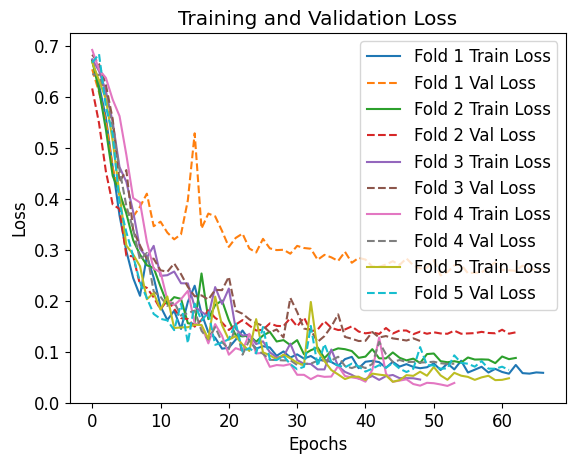

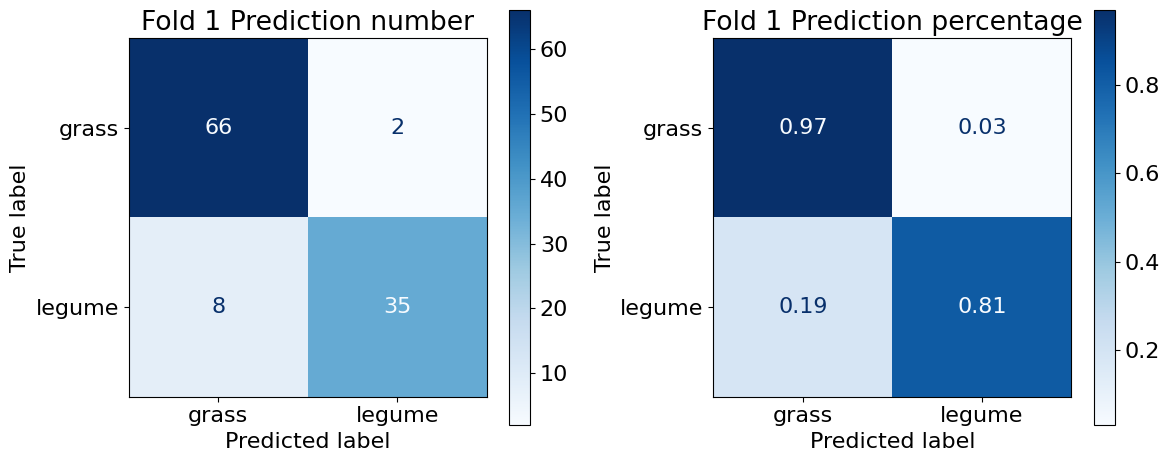

Fold 1 - Grass: Precision: 0.8919, Recall: 0.9706, Specificity: 0.8140, F1 Score: 0.9296
Fold 1 - Legume: Precision: 0.9459, Recall: 0.8140, Specificity: 0.9706, F1 Score: 0.8750
Fold 1 - Average: Precision: 0.9189, Recall: 0.8923, Specificity: 0.8923, F1 Score: 0.9023


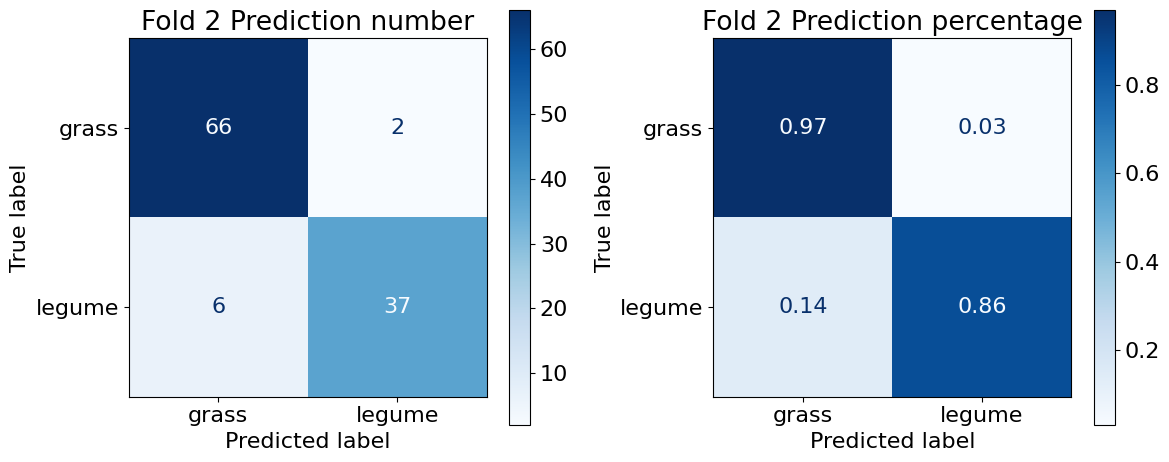

Fold 2 - Grass: Precision: 0.9167, Recall: 0.9706, Specificity: 0.8605, F1 Score: 0.9429
Fold 2 - Legume: Precision: 0.9487, Recall: 0.8605, Specificity: 0.9706, F1 Score: 0.9024
Fold 2 - Average: Precision: 0.9327, Recall: 0.9155, Specificity: 0.9155, F1 Score: 0.9226


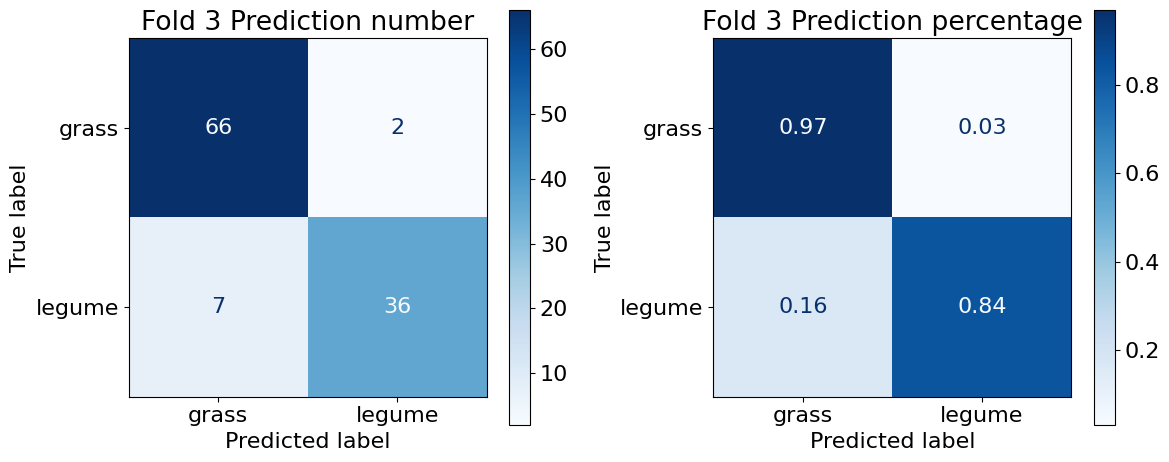

Fold 3 - Grass: Precision: 0.9041, Recall: 0.9706, Specificity: 0.8372, F1 Score: 0.9362
Fold 3 - Legume: Precision: 0.9474, Recall: 0.8372, Specificity: 0.9706, F1 Score: 0.8889
Fold 3 - Average: Precision: 0.9257, Recall: 0.9039, Specificity: 0.9039, F1 Score: 0.9125


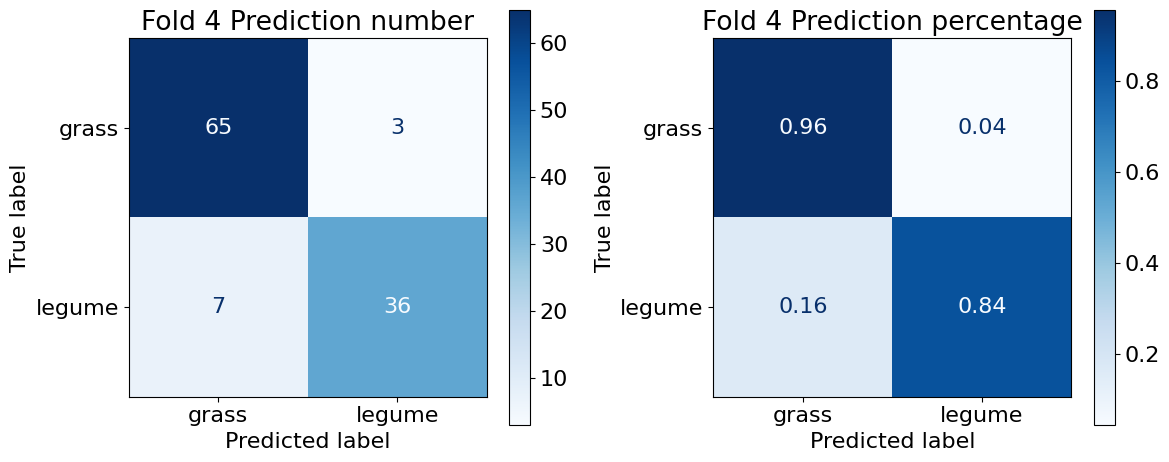

Fold 4 - Grass: Precision: 0.9028, Recall: 0.9559, Specificity: 0.8372, F1 Score: 0.9286
Fold 4 - Legume: Precision: 0.9231, Recall: 0.8372, Specificity: 0.9559, F1 Score: 0.8780
Fold 4 - Average: Precision: 0.9129, Recall: 0.8965, Specificity: 0.8965, F1 Score: 0.9033


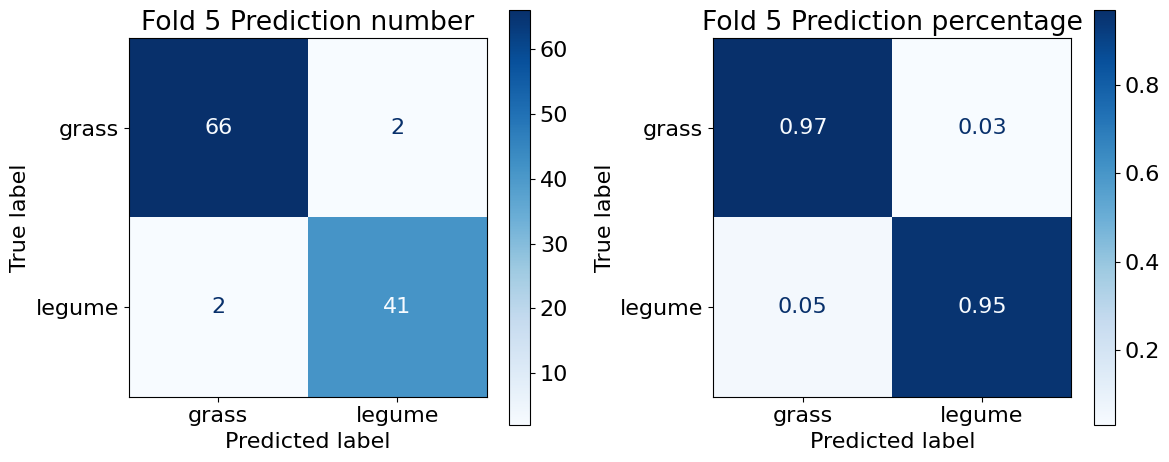

Fold 5 - Grass: Precision: 0.9706, Recall: 0.9706, Specificity: 0.9535, F1 Score: 0.9706
Fold 5 - Legume: Precision: 0.9535, Recall: 0.9535, Specificity: 0.9706, F1 Score: 0.9535
Fold 5 - Average: Precision: 0.9620, Recall: 0.9620, Specificity: 0.9620, F1 Score: 0.9620


In [9]:
# Example: No additional transformations 50 pixel
train_transform = None
test_transform = None
# Paths to training and testing folders
model_save_dir = './saved_models/split_grid/'
train_dir = './data/patch_grid/patch_50/train'
test_dir = './data/patch_grid/patch_50/test'

# Create dataset instances
train_dataset = GeoTIFFDataset(root_dir=train_dir, transform=train_transform)
test_dataset = GeoTIFFDataset(root_dir=test_dir, transform=test_transform)
num_classes = len(train_dataset.classes)  # Number of classes based on dataset

if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Step 3: Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Perform Cross-Validation
fold_results = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting Fold {fold + 1}")
    
    train_data = Subset(train_dataset, train_idx)
    val_data = Subset(train_dataset, val_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

    # Initialize model, criterion, optimizer, and scheduler
    model = SmallCNN4(input_channels=10, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # Train and validate the model
    train_loss, val_loss, cm, best_model_weights = train_and_validate_with_test(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=100,
        patience=15,
        device=device
    )

    torch.save(best_model_weights, os.path.join(model_save_dir, f'smallcnn4_fold{fold+1}_pad9_patch50.pth'))

    # Save results for this fold
    fold_results.append({
        'fold': fold + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'confusion_matrix': cm,
    })

plt.rcParams.update({'font.size': 12})
for result in fold_results:
    print(f"Fold {result['fold']}:")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    plt.plot(result['train_loss'], label=f"Fold {result['fold']} Train Loss")
    plt.plot(result['val_loss'], label=f"Fold {result['fold']} Val Loss", linestyle='dashed')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

plt.show()

plt.rcParams.update({'font.size': 16})

for result in fold_results:
    cm = result['confusion_matrix']

    norm_cm = cm / cm.sum(axis=1, keepdims=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    disp = ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes)
    disp.plot(cmap='Blues', xticks_rotation='horizontal', ax=axes[0])
    axes[0].set_title(f'Fold {result["fold"]} Prediction number')
    axes[0].set_ylabel('True label', rotation='vertical')

    disp = ConfusionMatrixDisplay(norm_cm, display_labels=train_dataset.classes)
    disp.plot(cmap='Blues', xticks_rotation='horizontal', values_format=".2f", ax=axes[1])
    axes[1].set_title(f'Fold {result["fold"]} Prediction percentage')
    axes[1].set_ylabel('True label', rotation='vertical')

    plt.tight_layout()
    plt.show()

    grass_precision = cm[0,0] / (cm[0,0] + cm[1,0] + 1e-6)
    grass_recall = cm[0,0] / (cm[0,0] + cm[0,1] + 1e-6)
    grass_sensitivity = grass_recall
    grass_specificity = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-6)
    grass_f1 = 2 * (grass_precision * grass_recall) / (grass_precision + grass_recall + 1e-6)

    legume_precision = cm[1,1] / (cm[1,1] + cm[0,1] + 1e-6)
    legume_recall = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-6)
    legume_sensitivity = legume_recall
    legume_specificity = cm[0,0] / (cm[0,0] + cm[0,1] + 1e-6)
    legume_f1 = 2 * (legume_precision * legume_recall) / (legume_precision + legume_recall + 1e-6)

    avg_precision = (grass_precision + legume_precision) / 2
    avg_sensitivity = (grass_sensitivity + legume_sensitivity) / 2
    avg_specificity = (grass_specificity + legume_specificity) / 2
    avg_f1 = (grass_f1 + legume_f1) / 2

    print(f"Fold {result['fold']} - Grass: Precision: {grass_precision:.4f}, Recall: {grass_recall:.4f}, Specificity: {grass_specificity:.4f}, F1 Score: {grass_f1:.4f}")
    print(f"Fold {result['fold']} - Legume: Precision: {legume_precision:.4f}, Recall: {legume_recall:.4f}, Specificity: {legume_specificity:.4f}, F1 Score: {legume_f1:.4f}")
    print(f"Fold {result['fold']} - Average: Precision: {avg_precision:.4f}, Recall: {avg_sensitivity:.4f}, Specificity: {avg_specificity:.4f}, F1 Score: {avg_f1:.4f}")
